In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## Extract Mel Spectrograms from Audio Files and Convert to DataFrame

In [2]:
def make_mel_spectrogram_df(directory):
    
    labels = []
    mel_specs = []
    
    for file in os.scandir(directory):
        y, sr = librosa.core.load(file)
        
         # Extracting the label and adding it to the list
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660
        if spect.shape[1] != 660:
           spect.resize(128,660, refcheck=False)
        
        spect = spect.flatten()
        mel_specs.append(spect)
        
    mel_specs = np.array(mel_specs)
    labels = np.array(labels).reshape(1000,1)
    
    # Create dataframe
    df = pd.DataFrame(np.hstack((mel_specs,labels)))

    return df

In [3]:
df = make_mel_spectrogram_df('../data/wavfiles')
df.to_csv('../data/genre_mel_specs.csv', index=False)

## Extract Numeric Features from Audio Files

In [4]:
def extract_audio_features(directory):
    
    # Creating an empty list to store all file names
    files = []
    labels = []
    zcrs = []
    spec_centroids = []
    spec_rolloffs = []
    mfccs_1 = []
    mfccs_2 = []
    mfccs_3 = []
    mfccs_4 = []
    mfccs_5 = []
    mfccs_6 = []
    mfccs_7 = []
    mfccs_8 = []
    mfccs_9 = []
    mfccs_10 = []
    mfccs_11 = []
    mfccs_12 = []
    mfccs_13 = []
    
    for file in os.scandir(directory):
        
        if file.name != '.DS_Store':
            y, sr = librosa.core.load(file)
            files.append(file)

            # Adding the label to our list of labels
            label = str(file).split('.')[0]
            labels.append(label)

            # zero-crossing rates
            zcr = librosa.feature.zero_crossing_rate(y)
            zcrs.append(np.mean(zcr))

            # spectral centroids
            spec_centroid = librosa.feature.spectral_centroid(y)
            spec_centroids.append(np.mean(spec_centroid))

            # spectral rolloffs
            spec_rolloff = librosa.feature.spectral_rolloff(y)
            spec_rolloffs.append(np.mean(spec_rolloff))

            # the first 13 mfcc coefficients
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
            mfcc_scaled = np.mean(mfcc.T, axis=0)
            mfccs_1.append(mfcc_scaled[0])
            mfccs_2.append(mfcc_scaled[1])
            mfccs_3.append(mfcc_scaled[2])
            mfccs_4.append(mfcc_scaled[3])
            mfccs_5.append(mfcc_scaled[4])
            mfccs_6.append(mfcc_scaled[5])
            mfccs_7.append(mfcc_scaled[6])
            mfccs_8.append(mfcc_scaled[7])
            mfccs_9.append(mfcc_scaled[8])
            mfccs_10.append(mfcc_scaled[9])
            mfccs_11.append(mfcc_scaled[10])
            mfccs_12.append(mfcc_scaled[11])
            mfccs_13.append(mfcc_scaled[12])
    
    # Creating a data frame with the values we collected
    df = pd.DataFrame({
        'files': files,
        'zero_crossing_rate': zcrs,
        'spectral_centroid': spec_centroids,
        'spectral_rolloff': spec_rolloffs,
        'mfcc_1': mfccs_1,
        'mfcc_2': mfccs_2,
        'mfcc_3': mfccs_3,
        'mfcc_4': mfccs_4,
        'mfcc_5': mfccs_5,
        'mfcc_6': mfccs_6,
        'mfcc_7': mfccs_7,
        'mfcc_8': mfccs_8,
        'mfcc_9': mfccs_9,
        'mfcc_10': mfccs_10,
        'mfcc_11': mfccs_11,
        'mfcc_12': mfccs_12,
        'mfcc_13': mfccs_13,
        'labels': labels
    })
    
    return df

In [5]:
df = extract_audio_features('../data/wavfiles')
df.to_csv('../data/genre.csv', index=False)
genre = pd.read_csv('../data/genre.csv')

## Creating Labels

In [6]:
genre['files'] = genre['files'].map(lambda x: x[11:-2])
genre['labels'] = genre['labels'].map(lambda x: x[11:])
label_map = {
    'blues': 1,
    'classical': 2,
    'country': 3,
    'disco': 4,
    'hiphop': 5,
    'jazz': 6,
    'metal': 7,
    'pop': 8,
    'reggae': 9,
    'rock': 10
}

genre['y'] = genre['labels'].map(label_map)
genre.to_csv('../data/genre_clean.csv', index=False)

## Mel Spectrogram Data

In [7]:
mel_specs = pd.read_csv('../data/genre_mel_specs.csv')

# Renaming the label column and mapping them to numeric values using the same map as above
mel_specs = mel_specs.rename(columns={'84480': 'labels'})
mel_specs['y'] = mel_specs['labels'].map(label_map)
mel_specs.to_csv('../data/genre_mel_specs_clean.csv', index=False)

mel_specs = pd.read_csv('../data/genre_mel_specs_clean.csv')

### Function to Get a Subset of the Genres

This function returns data with given genre

In [8]:
def get_genre_subset(data, genre_subset):

    df = data.loc[data['labels'].isin(genre_subset)]
    df = df.reset_index().drop(columns=['index'])
    
    new_label_dict = {}
    for i in range(len(genre_subset)):
        new_label_dict[genre_subset[i]] = i
    
    df['y'] = df['labels'].map(new_label_dict)

    return df

## Function to Preprocess the Features and Targets

    
Preprecessing steps include:
1. Reshaping the mel spectrograms to their original form (128 x 660)
2. Defining the array of targets
3. Train test split
4. Standardizing the data
5. Reshaping the data to be 128 x 660 x 1, where the 1 represents a single color channel
6. One-hot-encoding target data

In [9]:
def preprocess_mel_spec_data(data, genre_subset):

    subset = get_genre_subset(data, genre_subset)
    
    specs = subset.drop(columns=['labels', 'y'])
    
    X = []
    for i in range(len(genre_subset)*100):
        X.append(np.array(specs.iloc[i]).reshape(128,660))
        
    X = np.array(X)
    
    y = subset.loc[subset['labels'].isin(genre_subset), 'y'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)
    
    X_train /= -80
    X_test /= -80
    
    X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
    X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)
    
    y_train = to_categorical(y_train, len(genre_subset))
    y_test = to_categorical(y_test, len(genre_subset))
    
    return X_train, X_test, y_train, y_test

In [10]:
genre_list = [ 
    'jazz',
    'reggae',
    'rock',
    'blues',
    'hiphop',
    'country',
    'metal',
    'classical',
    'disco',
    'pop'
]

In [11]:
genre_subset = [
    'jazz',
    'hiphop',
    'country',
    'metal',
    'classical',
    'disco',
    'pop'
]

In [12]:
X_train, X_test, y_train, y_test = preprocess_mel_spec_data(mel_specs, genre_subset)
print(X_test.shape)

(140, 128, 660, 1)


## CNN Model for Subset of Genres

In [13]:
np.random.seed(23456)

cnn_model = Sequential(name='cnn_1')

cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

cnn_model.add(MaxPooling2D(pool_size=(2,4)))

cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(2,4)))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation='relu'))

cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(7, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)

Epoch 1/15
35/35 [==============================] - 18s 509ms/step - loss: 2.1364 - accuracy: 0.1446 - val_loss: 1.9385 - val_accuracy: 0.1429
Epoch 2/15
35/35 [==============================] - 20s 574ms/step - loss: 1.9387 - accuracy: 0.1375 - val_loss: 1.9330 - val_accuracy: 0.1857
Epoch 3/15
35/35 [==============================] - 18s 502ms/step - loss: 1.9261 - accuracy: 0.1625 - val_loss: 1.8958 - val_accuracy: 0.2500
Epoch 4/15
35/35 [==============================] - 19s 542ms/step - loss: 1.8752 - accuracy: 0.2536 - val_loss: 1.8713 - val_accuracy: 0.2214
Epoch 5/15
35/35 [==============================] - 18s 516ms/step - loss: 1.8078 - accuracy: 0.2839 - val_loss: 1.7373 - val_accuracy: 0.2786
Epoch 6/15
35/35 [==============================] - 17s 486ms/step - loss: 1.6698 - accuracy: 0.3625 - val_loss: 1.5172 - val_accuracy: 0.4857
Epoch 7/15
35/35 [==============================] - 17s 487ms/step - loss: 1.5044 - accuracy: 0.4125 - val_loss: 1.4138 - val_accuracy: 0.5000

In [14]:
# Checking the model summary
cnn_model.summary()
cnn_model.save('cnn_sub_classifier.h5')

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2457664   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

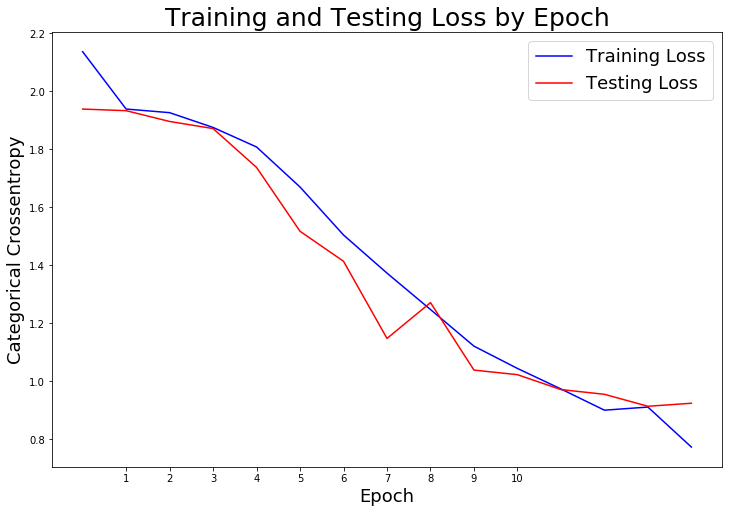

In [15]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']


plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,11), range(1,11))

plt.legend(fontsize = 18);

In [16]:
predictions = cnn_model.predict(X_test, verbose=1)

5/5 [==============================] - 1s 223ms/step


## Confusion Matrix

In [17]:
# List of a subset of the genres
genre_labels = {
    0:'jazz',
    1:'hiphop',
    2:'country',
    3:'metal',
    4:'classical',
    5:'disco',
    6:'pop'
}

In [18]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
confusion_df = pd.DataFrame(conf_matrix)
confusion_df = confusion_df.rename(columns=genre_labels)
confusion_df.index = confusion_df.columns




(7.0, 0)

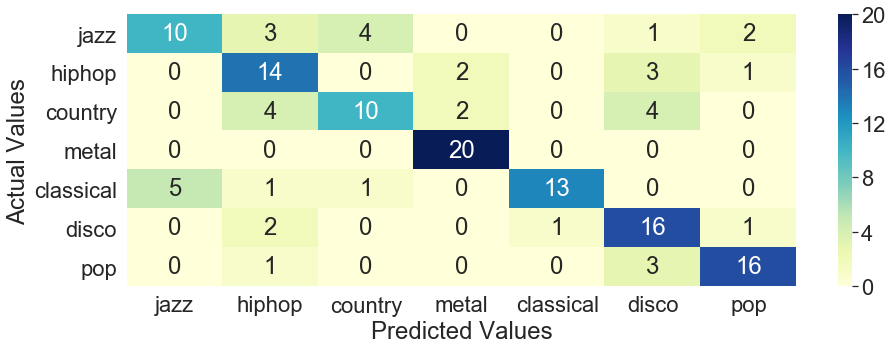

In [19]:
import seaborn as sns

plt.figure(figsize= (15,5))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True,cmap='YlGnBu');
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

ax.set_ylim(7.0, 0)

